**Image cutouts**  
@Author: Ray  
@Cite: [astropy.nddata](https://docs.astropy.org/en/stable/nddata/index.html#module-astropy.nddata) package  
@Time: 2022.07.10  
@Describe:  
* cutout: 从一个大的FITS图像中，根据目标源的位置，将其扣下来存成新的FITS文件  
* 官方文档[2D Cutout Images](https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images)

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord

from astropy.visualization import imshow_norm, PercentileInterval, MinMaxInterval, AsinhStretch, SqrtStretch

# ^ 禁用同一单元格内的输出覆盖
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

PATH_example = Path("/Users/rui/Code/1_Astronote/02_Astropy/example-data") / '5_1_image-cutout'

## Original image

In [2]:
# open the FITS image
hdul = fits.open(PATH_example / "hlsp_3d-dash_hst_wfc3_combined-t10.11-cosmos_f160w_v1.0_drz-sci.fits")
hdul.info()

Filename: /Users/rui/Code/1_Astronote/02_Astropy/example-data/5_1_image-cutout/hlsp_3d-dash_hst_wfc3_combined-t10.11-cosmos_f160w_v1.0_drz-sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     220   (4096, 4096)   float32   


In [3]:
# 读取data, header
hdu = hdul['PRIMARY']
data = hdu.data
header = hdu.header

# 用header创建wcs，用于pixel和ra/dec的转换
wcs = WCS(header)

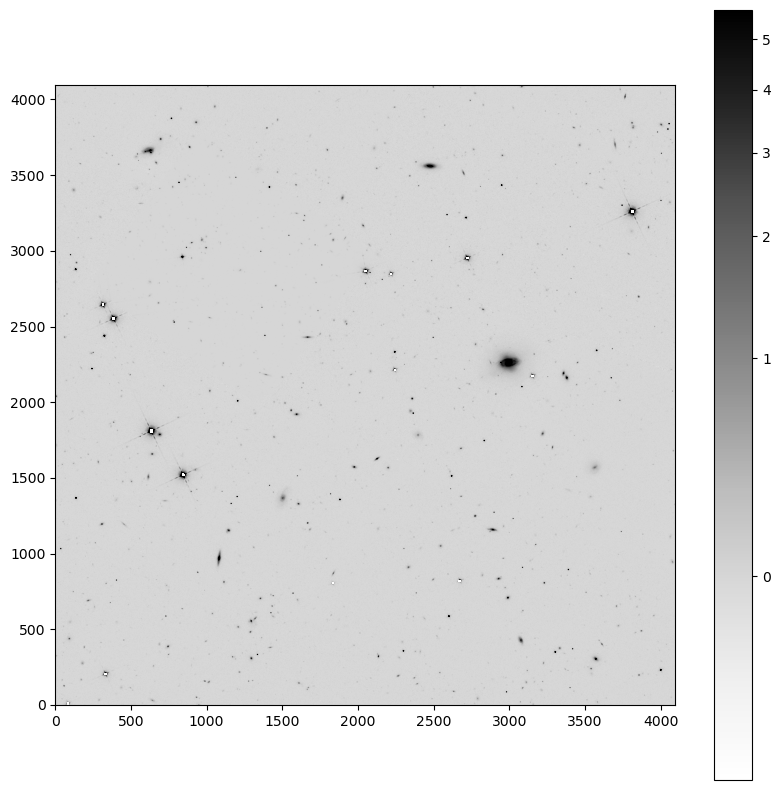

In [4]:
# plot the original image
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
im, norm = imshow_norm(data=data, ax=ax, origin='lower', interval=PercentileInterval(percentile=99.9), stretch=AsinhStretch(), cmap='Greys')
fig.colorbar(im)

## [Cutout2D](https://docs.astropy.org/en/stable/api/astropy.nddata.Cutout2D.html#astropy.nddata.Cutout2D)

使用pixels表示目标中心位置

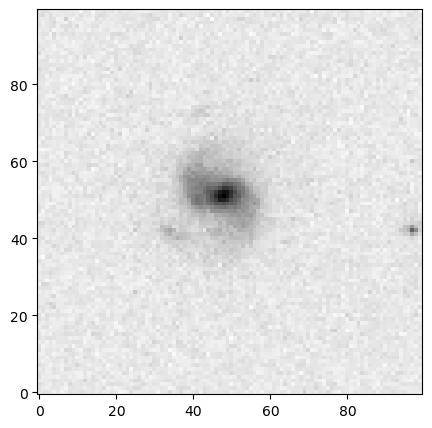

In [5]:
# set center_coordinate and size
position = (628.584, 2793.77) # pixels
size = (100, 100)  # pixels

cutout = Cutout2D(data=data, position=position, size=size)

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
im, norm = imshow_norm(data=cutout.data, ax=ax, origin='lower', interval=MinMaxInterval(), stretch=AsinhStretch(), cmap='Greys')

In [6]:
# 将像素坐标转换为赤道坐标，用于下面按赤道坐标定位目标源的练习
(x, y) = position
coord = wcs.pixel_to_world(x, y)
ra = coord.ra.value
dec = coord.dec.value
print("="*20 + " 目标源坐标 " + "="*20)
print("(x, y) = ({}, {})".format(x, y))
print("(ra, dec) = ({}, {})".format(ra, dec))

==================== 目标源坐标 ====================
(x, y) = (628.584, 2793.77)
(ra, dec) = (149.83870848962312, 2.6509271632123834)


使用ra/dec表示目标中心位置

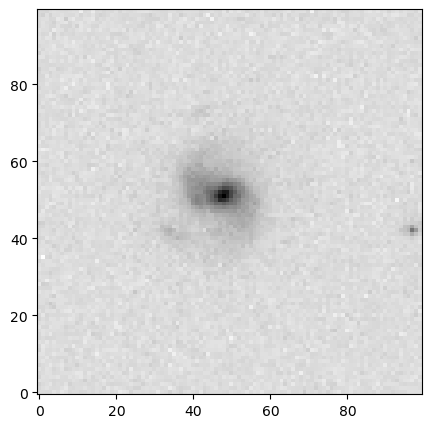

In [8]:
# set center_coordinate and size
coord = SkyCoord(149.83870848962312, 2.6509271632123834, unit='deg')
size = (100, 100)  # pixels

cutout = Cutout2D(data=data, position=coord, size=size, wcs=wcs)  # 用ra/dec时需要加上wcs参数

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
im, norm = imshow_norm(data=cutout.data, ax=ax, origin='lower', interval=MinMaxInterval(), stretch=SqrtStretch(), cmap='Greys')

`plot_on_original`: cutout在原图中的位置

<AxesSubplot:>

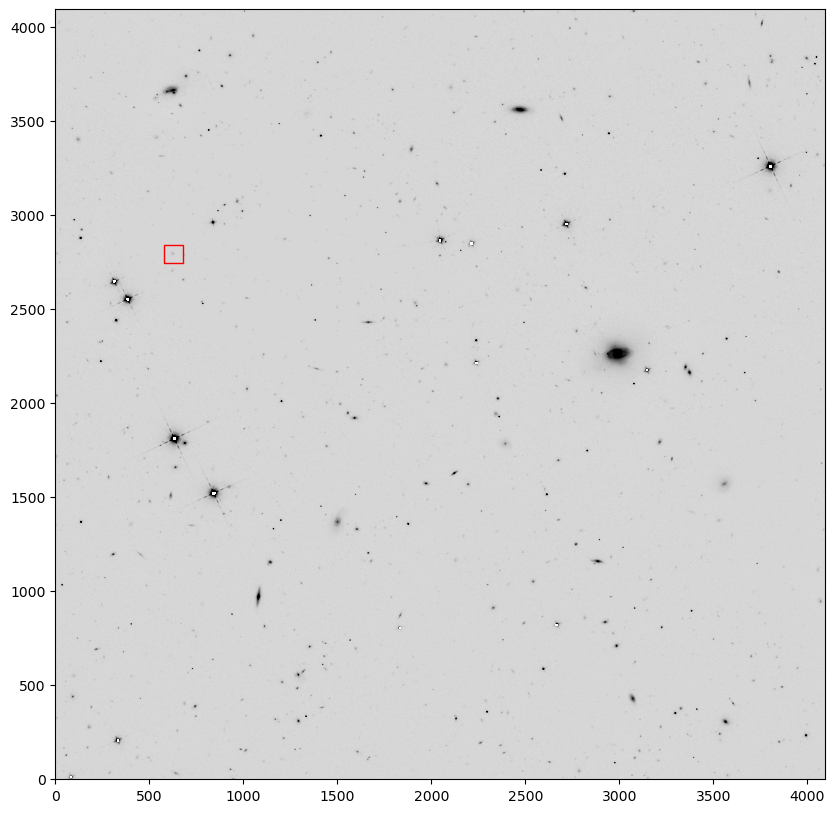

In [10]:
# 画出cutout在原始图像中的位置
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
im, norm = imshow_norm(data=data, ax=ax, origin='lower', interval=PercentileInterval(percentile=99.9), stretch=AsinhStretch(), cmap='Greys')
cutout.plot_on_original(ax=ax, color='red')

输出cutout的一些信息

In [11]:
# print some information

print("1. cutout的形状:")
cutout.shape

print("2. cutout的目标中心在原图上的像素坐标(取整后的):")
cutout.position_original

print("3. cutout的目标中心在原图上的像素坐标(input没取整):")
cutout.input_position_original

print("4. cutout的目标中心在cutout上的像素坐标(input没取整):")
cutout.input_position_cutout

print("5. cutout中的坐标(40, 40)在原图中的坐标:")
cutout.to_original_position((40, 40))

print("6. 原图坐标(1201, 2590)在cutout中的坐标:")
cutout.to_cutout_position((1201, 2590))


1. cutout的形状:


(100, 100)

2. cutout的目标中心在原图上的像素坐标(取整后的):


(629, 2794)

3. cutout的目标中心在原图上的像素坐标(input没取整):


(array(628.584), array(2793.77))

4. cutout的目标中心在cutout上的像素坐标(input没取整):


(49.58399999993526, 49.769999999591164)

5. cutout中的坐标(40, 40)在原图中的坐标:


(619, 2784)

6. 原图坐标(1201, 2590)在cutout中的坐标:


(622, -154)

# Saving a Cutout to a FITS File with an Updated WCS
* cite: https://docs.astropy.org/en/stable/nddata/utils.html#saving-a-2d-cutout-to-a-fits-file-with-an-updated-wcs

In [31]:
# 创建cutout的header
header_cutout = fits.Header(cards=header, copy=True)  # 产生一个与原图header一样的header
header_cutout.update(cutout.wcs.to_header())  # 将cutout的信息更新原header

# 报告header的区别
print(fits.HeaderDiff(header, header_cutout).report())

 Headers have different number of cards:
  a: 220
  b: 223
 Extra keyword 'MJD-OBS' in b: 57860.0
 Extra keyword 'PC1_1'  in b: -2.7777777777776e-05
 Extra keyword 'PC2_2'  in b: 2.7777777777778e-05
 Keyword CRPIX1   has different values:
    a> -8191.75
    b> -8770.75
 Keyword CRPIX2   has different values:
    a> -12287.75
    b> -15031.75
 Keyword DATE-OBS has different comments:
    a> Exposure start date (UT)
    b> ISO-8601 time of observation



In [36]:
hdu = fits.PrimaryHDU(data=cutout.data, header=header_cutout)
hdul = fits.HDUList([hdu])
hdul.writeto(PATH_example / 'cutout.fits', overwrite=True)

In [33]:
# 检查一下刚刚创建的FITS
hdul_check = fits.open(PATH_example / 'cutout.fits', overwrite=True)
hdul_check.info()

Filename: /Users/rui/Code/1_Astronote/02_Astropy/example-data/5_1_image-cutout/cutout.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     223   (100, 100)   float32   
